<a href="https://colab.research.google.com/github/hiya906/my-machine-learning/blob/master/Day_5_Unsupervised_Learning_and_TensorFlow_%EC%8B%A4%EC%8A%B5%EC%A0%95%EB%8B%B5%ED%8F%AC%ED%95%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#사용법

1. 우측 상단 '로그인'

2. 좌측 상단 '실습 모드에서 열기'

※ 각각의 셀은 셀 좌측 상단 실행 버튼을 통해 실행할 수 있습니다.

※ 실행 중 '경고: 이 노트는 Google에서 작성하지 않았습니다.'라는 창이 뜰 경우, '실행 전에 모든 런타임 재설정'란에 체크 후 '무시하고 계속하기'를 하시면 됩니다.

# 질문이 있으시다면...

아래의 메일주소로 연락주시면 답변드리겠습니다!

최민진(zxcvxd@skku.edu)

# Unsupervised Learning 1 - Classification
### * K-means & DBSCAN
### * Scikit-Learn을 활용하여 쉽게 사용할 수 있습니다

## 시각화를 위한 함수정의입니다. 

실행시켜 주세요

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
from sklearn.decomposition import PCA, NMF
from sklearn.externals.joblib import Memory

memory = Memory(cachedir="cache")

cm_cycle = ListedColormap(['#0000aa', '#ff5050', '#50ff50', '#9040a0', '#fff000'])
cm3 = ListedColormap(['#0000aa', '#ff2020', '#50ff50'])
cm2 = ListedColormap(['#0000aa', '#ff2020'])

# create a smooth transition from the first to to the second color of cm3
# similar to RdBu but with our red and blue, also not going through white,
# which is really bad for greyscale

cdict = {'red': [(0.0, 0.0, cm2(0)[0]),
                 (1.0, cm2(1)[0], 1.0)],

         'green': [(0.0, 0.0, cm2(0)[1]),
                   (1.0, cm2(1)[1], 1.0)],

         'blue': [(0.0, 0.0, cm2(0)[2]),
                  (1.0, cm2(1)[2], 1.0)]}

ReBl = LinearSegmentedColormap("ReBl", cdict)


def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

@memory.cache
def pca_faces(X_train, X_test):
    # copy and pasted from nmf. refactor?
    # Build NMF models with 10, 50, 100, 500 components
    # this list will hold the back-transformd test-data
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        # build the NMF model
        pca = PCA(n_components=n_components)
        pca.fit(X_train)
        # transform the test data (afterwards has n_components many dimensions)
        X_test_pca = pca.transform(X_test)
        # back-transform the transformed test-data
        # (afterwards it's in the original space again)
        X_test_back = pca.inverse_transform(X_test_pca)
        reduced_images.append(X_test_back)
    return reduced_images


def plot_pca_faces(X_train, X_test, image_shape):
    reduced_images = pca_faces(X_train, X_test)

    # plot the first three images in the test set:
    fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for i, ax in enumerate(axes):
        # plot original image
        ax[0].imshow(X_test[i].reshape(image_shape),
                     vmin=0, vmax=1)
        # plot the four back-transformed images
        for a, X_test_back in zip(ax[1:], reduced_images):
            a.imshow(X_test_back[i].reshape(image_shape), vmin=0, vmax=1)

    # label the top row
    axes[0, 0].set_title("Original")
    for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500, 2000]):
        ax.set_title("Component = %d" % n_components)


def nmf_faces(X_train, X_test):
    # Build NMF models with 10, 50, 100 and 500 components
    # this list will hold the back-transformd test-data
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        # build the NMF model
        nmf = NMF(n_components=n_components, random_state=0)
        nmf.fit(X_train)
        # transform the test data (afterwards has n_components many dimensions)
        X_test_nmf = nmf.transform(X_test)
        # back-transform the transformed test-data
        # (afterwards it's in the original space again)
        X_test_back = np.dot(X_test_nmf, nmf.components_)
        reduced_images.append(X_test_back)
    return reduced_images


def plot_nmf_faces(X_train, X_test, image_shape):
    reduced_images = nmf_faces(X_train, X_test)

    # plot the first three images in the test set:
    fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                             subplot_kw={'xticks': (), 'yticks': ()})
    for i, ax in enumerate(axes):
        # plot original image
        ax[0].imshow(X_test[i].reshape(image_shape),
                     vmin=0, vmax=1)
        # plot the four back-transformed images
        for a, X_test_back in zip(ax[1:], reduced_images):
            a.imshow(X_test_back[i].reshape(image_shape), vmin=0, vmax=1)

    # label the top row
    axes[0, 0].set_title("Original")
    for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500]):
        ax.set_title("Component = %d" % n_components)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='cache'", use "location='cache'" instead.
  


## 1. Kmeans Classification

### (1) 데이터 준비

In [2]:
from sklearn.datasets import make_blobs

# 인위적으로 2차원 데이터를 생성합니다
X, y = make_blobs(random_state=1)

print(len(X), len(y))
print(X[:10], y[:10])

100 100
[[ -0.79415228   2.10495117]
 [ -9.15155186  -4.81286449]
 [-11.44182631  -4.45781441]
 [ -9.76761777  -3.19133737]
 [ -4.53655648  -8.40186288]
 [ -6.26302115  -8.10666081]
 [ -6.38481234  -8.4730297 ]
 [ -9.20490564  -4.57687928]
 [ -2.76017908   5.55121358]
 [ -1.17104176   4.33091816]] [0 1 1 1 2 2 2 1 0 0]


(-15.880540867189191, 11.799220003780011)

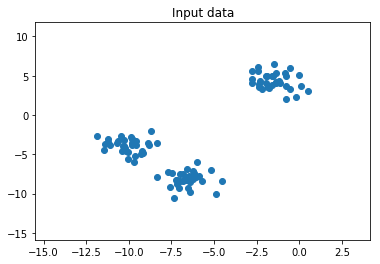

In [3]:
# X, y를 그림으로 나타내면 다음과 같습니다.
ax = plt.gca()
ax.set_title("Input data")
ax.plot(X[:,0], X[:,1], 'o')

ax.set_xlim(X[:,0].min() - X[:,0].std(), X[:,0].max() + X[:,0].std())
ax.set_ylim(X[:,1].min() - X[:,1].std(), X[:,1].max() + X[:,1].std())

### (2) K-means Algorithm



In [26]:
cur_center= X[:3]

arr = np.array([[1,2,3],[1,2,3]])
arr_sum_axis_0 = np.sum(arr, axis=0)
print(arr_sum_axis_0) #열연산
arr_sum_axis_1 = np.sum(arr, axis=1)
print(arr_sum_axis_1) #행연산

[2 4 6]
[6 6]


[0 2 2 2 1 1 1 2 0 0 2 2 1 0 1 1 1 0 2 2 1 2 1 0 2 1 1 0 0 1 0 0 1 0 2 1 2
 2 2 1 1 2 0 2 2 1 0 0 0 0 2 1 1 1 0 1 2 2 0 0 2 1 1 2 2 1 0 1 0 2 2 2 1 0
 0 2 1 1 0 2 0 2 2 1 0 0 0 0 2 0 1 0 0 2 2 1 1 0 1 0]


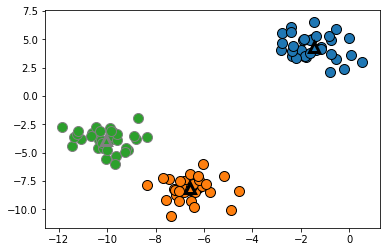

In [32]:
import numpy as np
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

#---------------None 부분을 작성해주세요!---------------
cur_center = X[:3]

prev_center = np.zeros_like(cur_center)

# update가 일어나지 않을 때까지 반복합니다.
while np.array_equal(prev_center, cur_center) == False :
  dist = pairwise_distances(X, cur_center) # 각 데이터와 Center 사이의 거리를 계산합니다.
  
  # 데이터를 가장 가까운 center에 배치합니다.
  labels = np.argmin(dist, axis=1)
  #print(labels)
 
  prev_center = cur_center # center를 업데이트하기 전, prev_center에 저장합니다.
  
  # center를 update합니다.
  cur_center = [X[np.where(labels == i)].mean(axis=0) for i in range(3)]
  #print(cur_center)

  
# 데이터 시각화 부분입니다.  
cur_center = np.array(cur_center)
discrete_scatter(X[:,0],X[:,1], labels, markers='o')
discrete_scatter(cur_center[:,0], cur_center[:,1],[0,1,2], markers='^', markeredgewidth=3)
print(labels)

#### 정답 코드입니다.

In [0]:
cur_center = X[:3]

prev_center = np.zeros_like(cur_center)


while np.array_equal(prev_center, cur_center) == False :
  dist = pairwise_distances(X, cur_center)
  labels = np.argmin(dist, axis=1)
  prev_center = cur_center
  cur_center = [X[np.where(labels == i)].mean(axis=0) for i in range(3)]
print(cur_center)
  
cur_center = np.array(cur_center)
discrete_scatter(X[:,0],X[:,1], labels, markers='o')
discrete_scatter(cur_center[:,0], cur_center[:,1],[0,1,2], markers='^', markeredgewidth=3)

### (3) Kmeans with Scikit-Learn

In [27]:
from sklearn.cluster import KMeans

# 군집 모델을 만듭니다
kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [35]:
#실행결과 확인
print(kmeans.labels_)
print(kmeans.cluster_centers_)

[0 1 3 2 1 0 1 0 2 0 3 2 0 2 3 2 3 1 3 2 3 1 0 3 3 2 1 1 0 0 3 2 0 1 3 2 1
 1 0 0 3 0 2 2 2 1 0 3 2 2 1 1 1 1 1 3 3 2 0 3 3 0 3 0 2 1 0 1 2 3 2 0 3 2
 3 3 1 2 3 0 2 2 3 1 1 0 2 0 2 1 3 1 1 1 2 0 0 3 0 0]
[[ 0.5844236  -1.47525095]
 [ 6.48445673 -9.14954979]
 [-7.96482369  1.72037388]
 [ 8.0783672  -3.28355269]]


IndexError: ignored

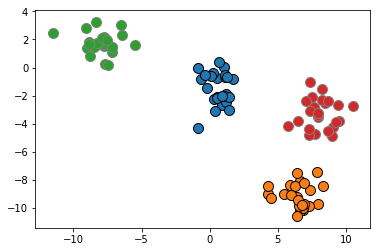

In [36]:
# 데이터를 그래프로 표현하기 위한 함수입니다.
# def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None, labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None)
# x1 : input data, first axis
# x2 : input data, sexond axis
# y : input data, discrete labels

discrete_scatter(X[:,0],X[:,1], kmeans.labels_, markers='o')
discrete_scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],[0,1,2], markers='^', markeredgewidth=3)

### (4) 실습

#### 위의 예시를 참고해서, X, y를 적절히 분류해보세요

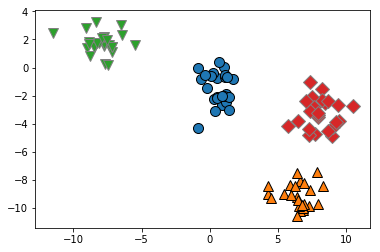

In [34]:
X, y = make_blobs(centers=4, random_state=6)

labels = np.zeros(len(X))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

labels = kmeans.labels_
#-----------------------------------------------------
discrete_scatter(X[:,0],X[:,1], labels)

## 2. DBSCAN

In [0]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.cluster import DBSCAN

### (1) 데이터 준비

In [0]:
# 인위적으로 2차원 데이터를 생성합니다
X, y = make_blobs(random_state=1)

### (2) DBSCAN 알고리즘 실행

In [62]:
dbscan = DBSCAN(eps=2, min_samples=20)
dbscan.fit(X)

DBSCAN(algorithm='auto', eps=2, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=20, n_jobs=None, p=None)

### (3) 실행결과 확인

In [58]:
print(dbscan.labels_)

[1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1
 1 0 0 0 1 0 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1]


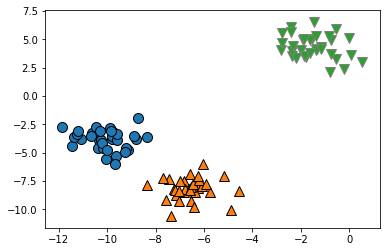

In [63]:
discrete_scatter(X[:,0],X[:,1], dbscan.labels_)

## 3. 실습1_여러 데이터 분포위에서 군집화

### (1) DBSCAN의 파라미터(eps, min_samples)를 조정하여 데이터를 적절히 분류해보세요.

ex. dbscan = DBSCAN(eps=0.5, min_samples=5)

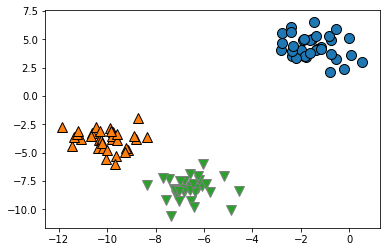

In [66]:
X, y = make_blobs(random_state = 1)

labels = np.zeros(len(X))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.


dbscan = DBSCAN(eps=2, min_samples=10)
dbscan.fit(X)

labels = dbscan.labels_

#-----------------------------------------------------
discrete_scatter(X[:,0],X[:,1], labels)

### (2) K-mean 혹은 DBSCAN을 활용하여 데이터를 분류해보세요

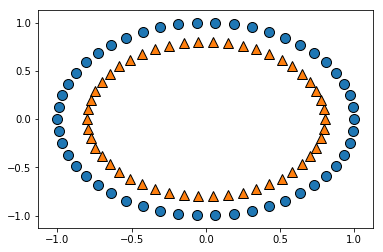

In [109]:
from sklearn.datasets import make_circles
X, y = make_circles()

labels = np.zeros(len(X))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.
# kmeans = KMeans(n_clusters=2)
# kmeans.fit(X)


dbscan = DBSCAN(eps = 0.15, min_samples=3)
dbscan.fit(X)
labels = dbscan.labels_


#-----------------------------------------------------
discrete_scatter(X[:,0],X[:,1], labels)

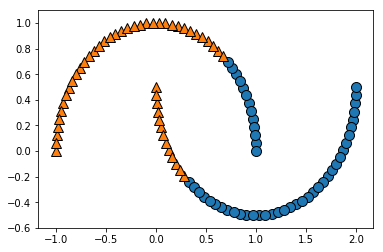

In [110]:
from sklearn.datasets import make_moons
X, y = make_moons()

labels = np.zeros(len(X))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.

# dbscan = DBSCAN(eps = 0.15, min_samples=3)
# dbscan.fit(X)
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
labels = kmeans.labels_



#-----------------------------------------------------
discrete_scatter(X[:,0],X[:,1], labels)

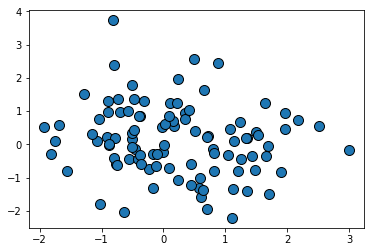

In [91]:
from sklearn.datasets import make_gaussian_quantiles
X, y = make_gaussian_quantiles()

labels = np.zeros(len(X))
#-----------------------------------------------------
# 이 곳에 코드를 작성하세요.




#-----------------------------------------------------
discrete_scatter(X[:,0],X[:,1], labels)

## 4. 실습2_문서 군집화

아래의 코드를 참고하였습니다.

https://github.com/brenden17/clustering-docs/blob/master/kmeans.py



데이터 파일을 왼쪽 '파일'란에 끌어서 업로드 해주세요.

밑의 화면처럼 표시되면 됩니다.

![파일 란_캡처](https://github.com/jin530/190428_unsupervised_tensorflow/blob/master/image/example2.PNG?raw=true)

### (1) 데이터 준비

In [0]:
# 형태소 파일을 불러옵니다.
files = ['/content/no1_noun.txt',
           '/content/no2_noun.txt',
           '/content/no3_noun.txt',
           '/content/park1_noun.txt',
           '/content/park2_noun.txt',
           '/content/park3_noun.txt']

# 각 파일을 read()하여 data라는 list에 넣어줍니다.
data = []
for file in files:
  with open(file, 'r') as f:
    rawdata = f.read()
  data.append(rawdata)

print(data[0])

### (2) 데이터 전처리

In [0]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# 문서를 단어 등장 횟수의 행렬로 변환해줍니다.
vectorizer = CountVectorizer(max_df=4, min_df=2)
counts = vectorizer.fit_transform(data)
print(counts.shape)

### (3) Kmeans 군집화 실행

In [0]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2)     
km.fit(counts)
print(km.labels_)

# Unsupervised Learning 2 - Dimensionality Reduction
### * PCA & NMF
### * Scikit-Learn을 활용하여 쉽게 사용할 수 있습니다

책 '파이썬 라이브러리를 활용한 머신러닝, 안드레아스 뮐러 외 1명'을 참고하였습니다.

## 1. 데이터 준비

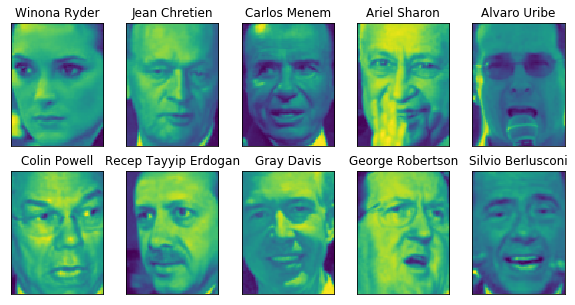

In [121]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt


# 2000년대 초반 이후의 정치인, 가수, 배우, 운동선수들의 얼굴을 포함하는 데이터셋입니다.
lfw_people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for target, image, ax in zip(lfw_people.target, lfw_people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(lfw_people.target_names[target])

In [122]:
print(lfw_people.data.shape) # 데이터가 어떤 형태인지
print(lfw_people.images.shape) # 데이터를 이미지로 변환했을때 어떤 형태인지
print(lfw_people.target.shape) # 데이터의 정답이 어떤 형태인지
print(len(lfw_people.target_names)) # 데이터가 총 몇명의 얼굴로 구성되어 있는지

(3023, 5655)
(3023, 87, 65)
(3023,)
62


In [123]:
import numpy as np
lfw_counts = np.bincount(lfw_people.target) # 각 클래스별 빈도 계산
for (name, count) in zip(lfw_people.target_names, lfw_counts):
    print("{0:25} {1:4}".format(name, count)) # (이름, 빈도 수) 출력

Alejandro Toledo            39
Alvaro Uribe                35
Amelie Mauresmo             21
Andre Agassi                36
Angelina Jolie              20
Ariel Sharon                77
Arnold Schwarzenegger       42
Atal Bihari Vajpayee        24
Bill Clinton                29
Carlos Menem                21
Colin Powell               236
David Beckham               31
Donald Rumsfeld            121
George Robertson            22
George W Bush              530
Gerhard Schroeder          109
Gloria Macapagal Arroyo     44
Gray Davis                  26
Guillermo Coria             30
Hamid Karzai                22
Hans Blix                   39
Hugo Chavez                 71
Igor Ivanov                 20
Jack Straw                  28
Jacques Chirac              52
Jean Chretien               55
Jennifer Aniston            21
Jennifer Capriati           42
Jennifer Lopez              21
Jeremy Greenstock           24
Jiang Zemin                 20
John Ashcroft               53
John Neg

In [124]:
# 각 사람당 최대 50개의 이미지만 사용합니다.
mask = np.zeros(lfw_people.target.shape, dtype=np.bool)
for target in np.unique(lfw_people.target):
    mask[np.where(lfw_people.target==target)[0][:50]] = True 

#데이터의 수가 3023개에서 2063개로 줄게 됩니다.
X_people = lfw_people.data[mask]
y_people = lfw_people.target[mask]
X_people = X_people/255	 # 픽셀 크기를 0~1 사이로 조정
print(X_people.shape) # output = (2063, 5655)
print(y_people.shape) # output = (2063,)

(2063, 5655)
(2063,)


In [127]:
from sklearn.model_selection import train_test_split

#기본 비율을 train:test = 3:1 이며, test_size, train_size라는 인자를 통해 조절할 수 있습니다.
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, random_state=0)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1547, 5655)
(516, 5655)
(1547,)
(516,)


## 2-2. PCA 알고리즘 실행

In [116]:
from sklearn.decomposition import PCA

# train 데이터를 통해 PCA를 훈련시켜, 주성분을 추출합니다. 
pca=PCA(n_components=100, whiten=True, random_state=0).fit(X_train)

X_train_pca = pca.transform(X_train) # X_train에 차원축소 방법인 PCA 적용 
X_test_pca = pca.transform(X_test) # X_test에 차원축소 방법인 PCA 적용 
print(X_train_pca.shape)
print(X_test_pca.shape)

X_train_back = pca.inverse_transform(X_train_pca) # X_train_pca를 원래 데이터로 복구 
X_test_back = pca.inverse_transform(X_test_pca) # X_test_pca를 원래 데이터로 복구 
print(X_train_back.shape)
print(X_test_back.shape)

(1547, 100)
(516, 100)
(1547, 5655)
(516, 5655)


### 실행결과 확인

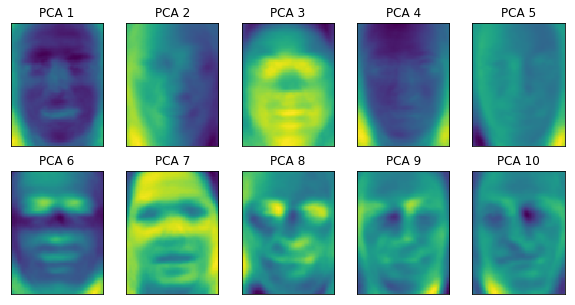

In [117]:
# pca.components_를 통해 PCA의 주성분을 확인할 수 있습니다.

import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})

image_shape = lfw_people.images[0].shape	 # output = (87, 65)

for i, (component, ax) in enumerate(zip(pca.components_,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("PCA {}".format((i+1)))

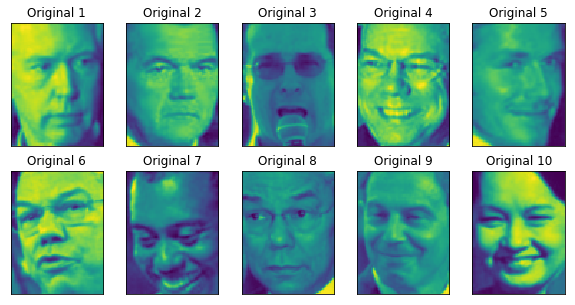

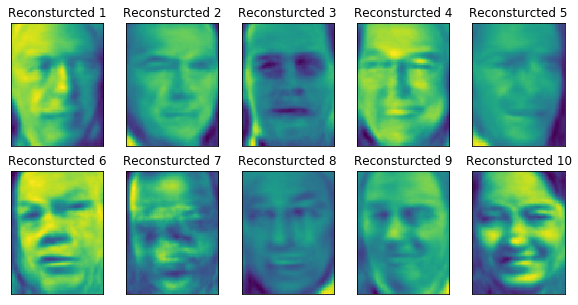

In [118]:
# Train 데이터가 pca를 통해 잘 복원되는지 확인합니다.

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train_back, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

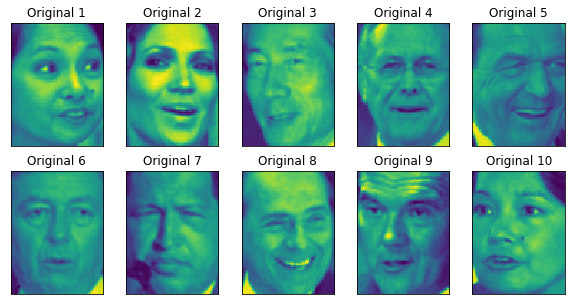

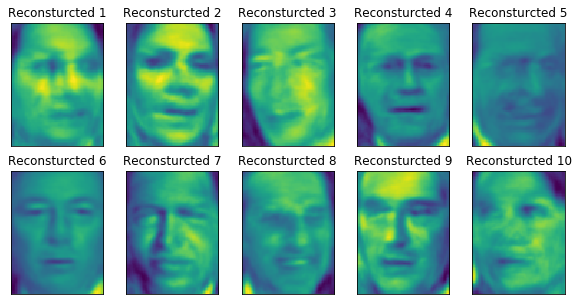

In [119]:
# Test 데이터가 pca를 통해 잘 복원되는지 확인합니다.


fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test_back,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

________________________________________________________________________________
[Memory] Calling __main__--content-__ipython-input__.pca_faces...
pca_faces(array([[0.780392, ..., 0.091503],
       ...,
       [0.227451, ..., 0.930719]], dtype=float32), 
array([[0.069281, ..., 0.428758],
       ...,
       [0.159477, ..., 0.573856]], dtype=float32))
________________________________________________________pca_faces - 5.2s, 0.1min


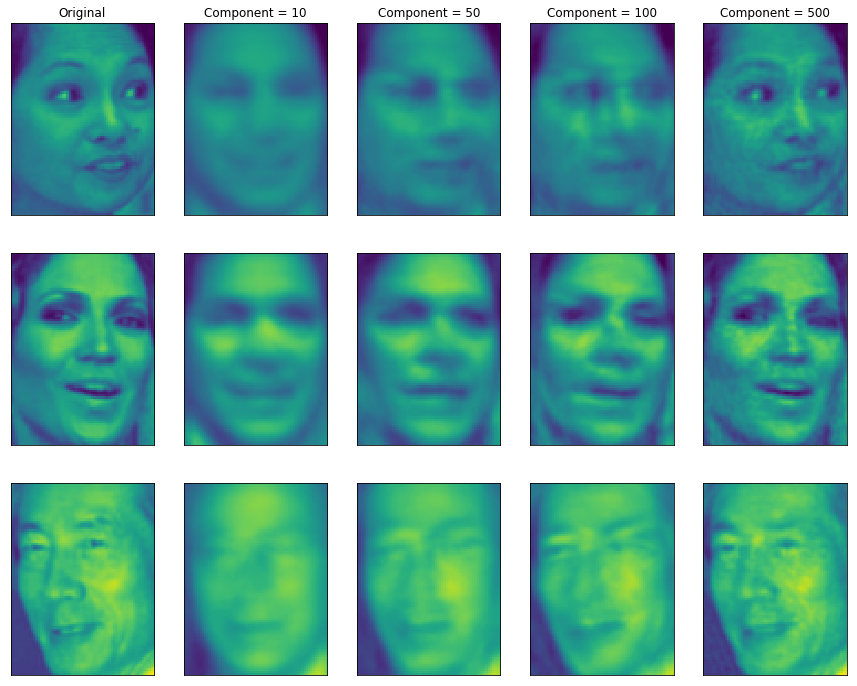

In [120]:
plot_pca_faces(X_train, X_test, image_shape)

## 2-1. NMF 알고리즘 실행

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html

In [141]:
from sklearn.decomposition import NMF

# n_components 는 PCA와 동일하게 해주세요.
nmf=NMF(n_components=100, random_state=0).fit(X_train)

X_train_nmf = nmf.transform(X_train) # X_train에 차원축소 방법인 NMF 적용 
X_test_nmf = nmf.transform(X_test) # X_test에 차원축소 방법인 NMF 적용 
print(X_train_nmf.shape)
print(X_test_nmf.shape)

X_train_back = nmf.inverse_transform(X_train_nmf) # X_train_nmf를 원래 데이터로 복구 
X_test_back = nmf.inverse_transform(X_test_nmf) # X_test_nmf를 원래 데이터로 복구 
print(X_train_back.shape)
print(X_test_back.shape)

(1547, 100)
(516, 100)
(1547, 5655)
(516, 5655)


### 정답코드 입니다.

In [0]:
from sklearn.decomposition import NMF

# train 데이터를 통해 NMF 모델을 학습시킵니다.
nmf = None

X_train_nmf = nmf.transform(X_train) # X_train에 차원축소 방법인 NMF 적용 
X_test_nmf = nmf.transform(X_test) # X_test에 차원축소 방법인 NMF 적용 
print(X_train_nmf.shape)
print(X_test_nmf.shape)

X_train_back = nmf.inverse_transform(X_train_nmf) # X_train_nmf를 원래 데이터로 복구 
X_test_back = nmf.inverse_transform(X_test_nmf) # X_test_nmf를 원래 데이터로 복구 
print(X_train_back.shape)
print(X_test_back.shape)

### 실행결과 확인

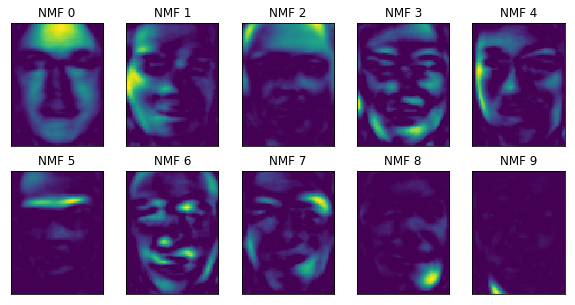

In [142]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks':(), 'yticks':()})

for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("NMF {}".format((i)))

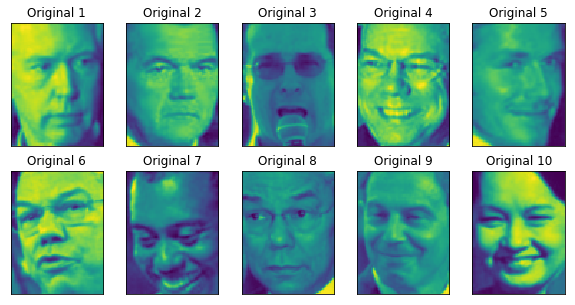

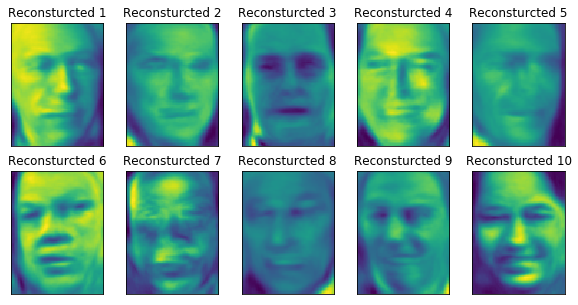

In [143]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_train_back,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

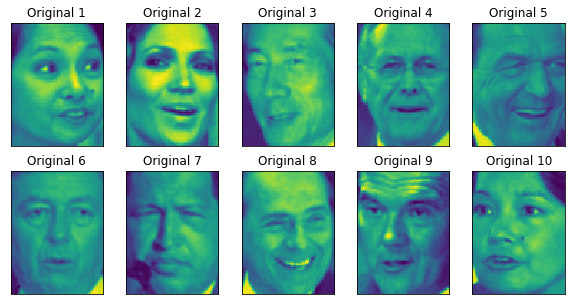

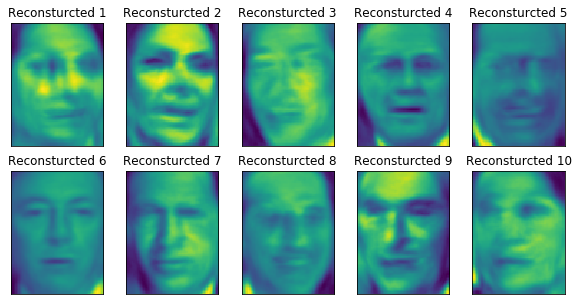

In [144]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Original {}".format((i+1)))

fig, axes = plt.subplots(2, 5, figsize=(10, 5), 	subplot_kw={'xticks':(), 'yticks':()})
for i, (component, ax) in enumerate(zip(X_test_back,axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("Reconsturcted {}".format((i+1)))

In [145]:
plot_nmf_faces(X_train, X_test, image_shape) # time: 8.8min

KeyboardInterrupt: ignored

## 3. PCA & NMF 종합

Text(0, 0.5, 'NMF')

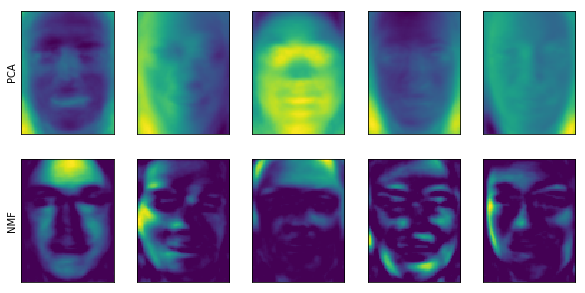

In [146]:
# 각 모델에서 특성을 추출하여 시각화 하는 코드입니다.

fig, axes = plt.subplots(2, 5, figsize=(10, 5), subplot_kw={'xticks': (), 'yticks':()})
for ax, fe_pca, fe_nmf in zip(axes.T, pca.components_, nmf.components_):
    ax[0].imshow(fe_pca.reshape(image_shape))
    ax[1].imshow(fe_nmf.reshape(image_shape))

axes[0,0].set_ylabel("PCA")
axes[1,0].set_ylabel("NMF")

Text(0, 0.5, 'NMF')

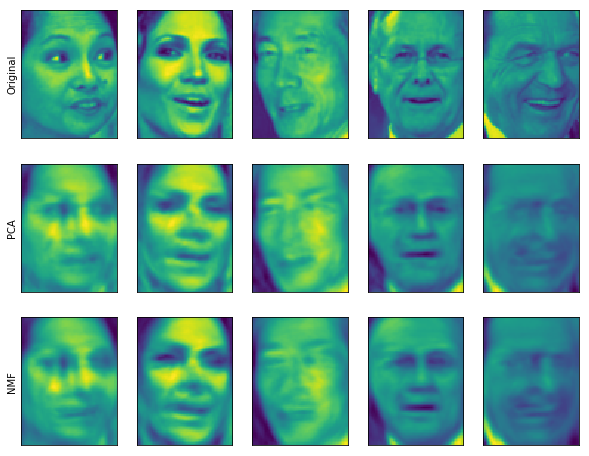

In [147]:
# 각 모델이 재구성한 이미지를 시각화하는 코드입니다.

X_reconstructed_pca=pca.inverse_transform(pca.transform(X_test))
X_reconstructed_nmf=np.dot(nmf.transform(X_test), nmf.components_)

fig, axes=plt.subplots(3, 5, figsize=(10, 8), subplot_kw={'xticks': (),'yticks':()})
for ax, ori, ir_pca, ir_nmf in zip(axes.T, X_test, X_reconstructed_pca,X_reconstructed_nmf):
    ax[0].imshow(ori.reshape(image_shape))
    ax[1].imshow(ir_pca.reshape(image_shape))
    ax[2].imshow(ir_nmf.reshape(image_shape))

axes[0,0].set_ylabel("Original")
axes[1,0].set_ylabel("PCA")
axes[2,0].set_ylabel("NMF")

# 추가실습

MNIST 데이터를 군집화해보세요

주의) 100% 정확도로 군집화하기는 어렵습니다. 

[[  0   0   0 177   0   1   0   0   0   0]
 [  1   0   0   0  99   0   2  24  55   1]
 [  0   2   3   1   8   0   0 148   2  13]
 [  2  12   7   0   7   0   0   0   0 155]
 [  0   0   9   0   3 164   0   0   5   0]
 [136  42   0   0   0   2   1   0   0   1]
 [  0   0   0   1   2   0 177   0   1   0]
 [  1   0 174   0   2   0   0   0   2   0]
 [  4  50   5   0 102   0   2   3   6   2]
 [  6 139   7   0   2   0   0   0  20   6]]


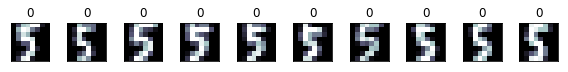

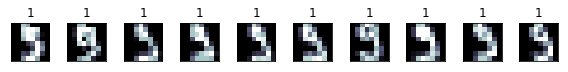

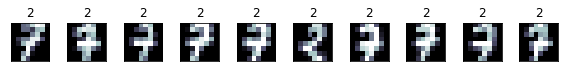

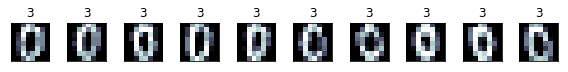

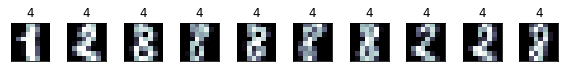

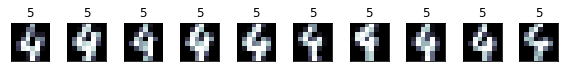

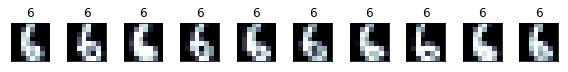

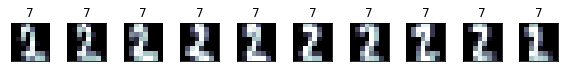

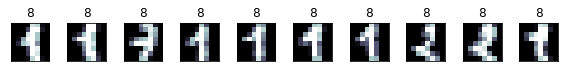

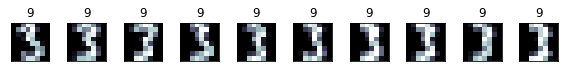

In [173]:
from sklearn.datasets import load_digits

MNIST = load_digits()

y_pred = np.random.randint(10, size = MNIST.data.shape[0])

#--------------------------------------
# y_pred에 새로운 clustering 결과를 할당해주세요!
# print(y_pred.shape)
#K-mean
kmeans = KMeans(n_clusters=10)
kmeans.fit(MNIST.data)
y_pred = kmeans.labels_
# print(y_pred.shape)

#DBSCAN
# dbscan = DBSCAN(eps = 16, min_samples=3)
# dbscan.fit(MNIST.data)
# y_pred = dbscan.labels_



#--------------------------------------


# 실제 정답과 분류 결과를 비교합니다.
from sklearn.metrics import confusion_matrix

print(confusion_matrix(MNIST.target, y_pred))


# 분류가 잘 되었는지 시각화 할 수 있는 부분입니다.
def show_digits(images, labels):
    f = plt.figure(figsize=(8, 2))
    i = 0
    while (i < 10 and i < images.shape[0]):
        ax = f.add_subplot(1, 10, i + 1)
        ax.imshow(images[i], cmap=plt.cm.bone)
        ax.grid(False)
        ax.set_title(labels[i])
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        plt.tight_layout()
        i += 1
        
def show_cluster(images, y_pred, cluster_number):
    images = images[y_pred == cluster_number]
    y_pred = y_pred[y_pred == cluster_number]
    show_digits(images, y_pred)
    

for i in range(10):
    show_cluster(MNIST.images, y_pred, i)